In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Tue Aug  2 16:24:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 73%   84C    P2   168W / 260W |   5339MiB / 11019MiB |     96%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 33%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_us = db.rm_patent_us
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2015 = db.rm_patent_us_2015
    db_rm_us_2015 = db.rm_patent_us_2015
    # db_rm_de_2015 = db.rm_patent_de_2015
except errors.ConnectionFailure as err:
    print(err)

# 2015

## Company數量

In [6]:
data_assignee = db_rm_us_2015.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [7]:
# 取總數前15家公司
# final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
df_family_us.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(16)

,company,count
24,Samsung Electronics Co Ltd,322
10,Intel Corp,260
27,Telefonaktiebolaget LM Ericsson AB,86
22,Qualcomm Inc,83
6,Cisco Technology Inc,50
1,Afero Inc,48
12,International Business Machines Corp,46
18,Microsoft Technology Licensing LLC,45
7,Convida Wireless LLC,34
3,Apple Inc,32


In [8]:
# com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df = df_family_us.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df.reset_index(drop=True, inplace=True)

In [9]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,Samsung Electronics Co Ltd,322,5.774552
1,Intel Corp,260,5.560682
2,Telefonaktiebolaget LM Ericsson AB,86,4.454347
3,Qualcomm Inc,83,4.418841
4,Cisco Technology Inc,50,3.912023
5,Afero Inc,48,3.871201
6,International Business Machines Corp,46,3.828641
7,Microsoft Technology Licensing LLC,45,3.806662
8,Convida Wireless LLC,34,3.526361
9,Apple Inc,32,3.465736


In [10]:
com_ls = list(com_df.company)

## Data

In [11]:
ccontry = pd.read_csv("../patent/code/依年分/rm_company_country_us_2015.csv")
ccpc = pd.read_csv("../LDA/company_lda_brief_us_2015.csv")

In [12]:
ccontry[ccontry.company.isin(com_ls)]

,company,AR,AU,BR,CA,CN,DE,DK,EA,EP,...,MY,PH,PL,PT,RU,SA,SG,TW,US,ZA
21,Afero Inc,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,0.0
35,Apple Inc,0.0,1.0,10.0,1.0,42.0,6.0,0.0,0.0,44.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,16.0,54.0,0.0
89,Cisco Technology Inc,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0
93,Convida Wireless LLC,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0
125,Electronics and Telecommunications Research In...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0
201,Intel Corp,0.0,0.0,12.0,0.0,115.0,20.0,0.0,0.0,104.0,...,0.0,0.0,0.0,0.0,2.0,0.0,3.0,36.0,284.0,0.0
209,International Business Machines Corp,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0
242,LG Electronics Inc,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.0,0.0
279,Microsoft Technology Licensing LLC,0.0,1.0,1.0,1.0,19.0,0.0,0.0,0.0,19.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,45.0,0.0
294,Nokia Solutions and Networks Oy,0.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,21.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,27.0,1.0


## Similarity計算

### Country

- 換成機率  

In [13]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [14]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AR,AU,BR,CA,CN,DE,DK,EA,EP,ES,...,MY,PH,PL,PT,RU,SA,SG,TW,US,ZA
company,,,,,,,,,,,,,,,,,,,,,
Samsung Electronics Co Ltd,0.000000,0.009719,0.000000,0.002160,0.140389,0.009719,0.000000,0.0,0.138229,0.005400,...,0.0,0.000000,0.000000,0.0,0.001080,0.0,0.000000,0.014039,0.361771,0.000000
Intel Corp,0.000000,0.000000,0.018377,0.000000,0.176110,0.030628,0.000000,0.0,0.159265,0.003063,...,0.0,0.000000,0.000000,0.0,0.003063,0.0,0.004594,0.055130,0.434916,0.000000
Telefonaktiebolaget LM Ericsson AB,0.016667,0.008333,0.020833,0.008333,0.125000,0.000000,0.008333,0.0,0.300000,0.020833,...,0.0,0.008333,0.008333,0.0,0.008333,0.0,0.000000,0.012500,0.358333,0.016667
Qualcomm Inc,0.000000,0.010000,0.040000,0.006667,0.176667,0.000000,0.000000,0.0,0.163333,0.016667,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.003333,0.053333,0.276667,0.000000
Cisco Technology Inc,0.000000,0.000000,0.000000,0.031250,0.015625,0.000000,0.000000,0.0,0.156250,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.781250,0.000000


In [15]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [16]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [17]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [18]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [19]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

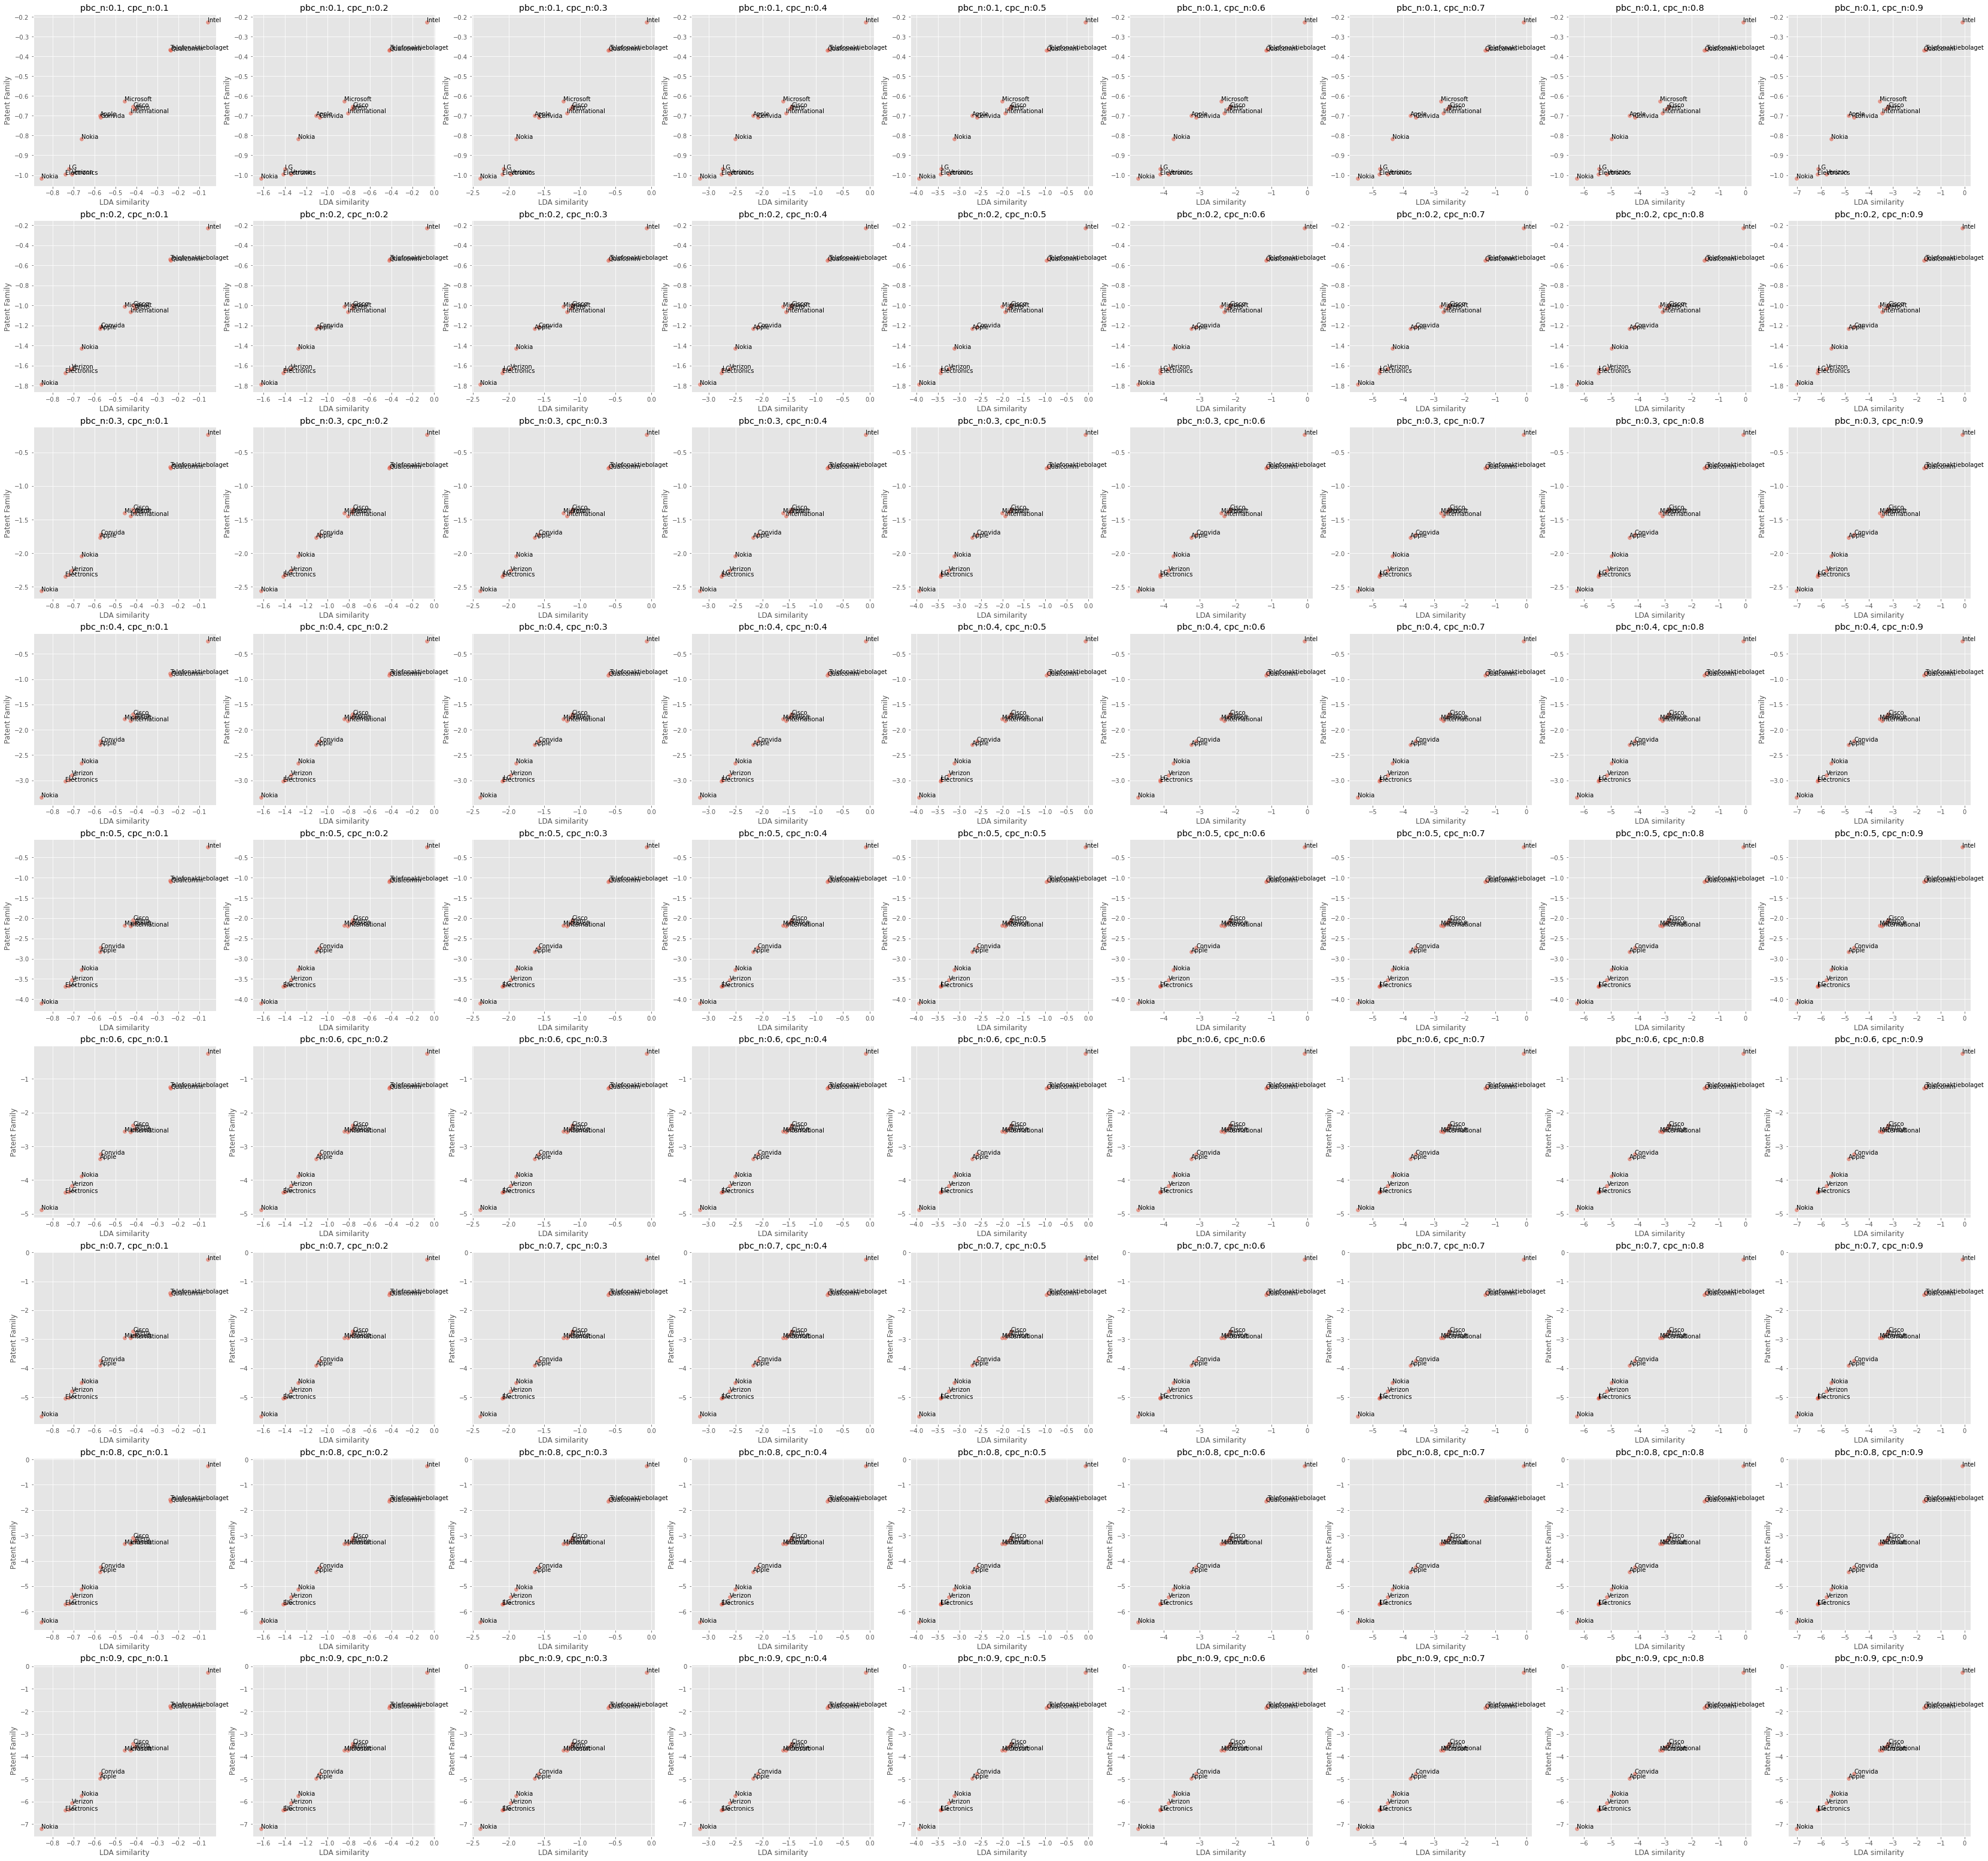

In [20]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("LDA similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_us_brief_2015_1.png'.format(pbc_n))

In [21]:
c_df

,cpc,country
company,,
Intel Corp,0.097091,0.263031
Telefonaktiebolaget LM Ericsson AB,1.635343,1.760618
Qualcomm Inc,1.707364,1.839722
Cisco Technology Inc,3.192049,3.428874
Afero Inc,3.307829,3.564832
International Business Machines Corp,3.457667,3.715117
Microsoft Technology Licensing LLC,3.555239,3.723708
Convida Wireless LLC,4.614144,4.752073
Apple Inc,4.838328,4.963882


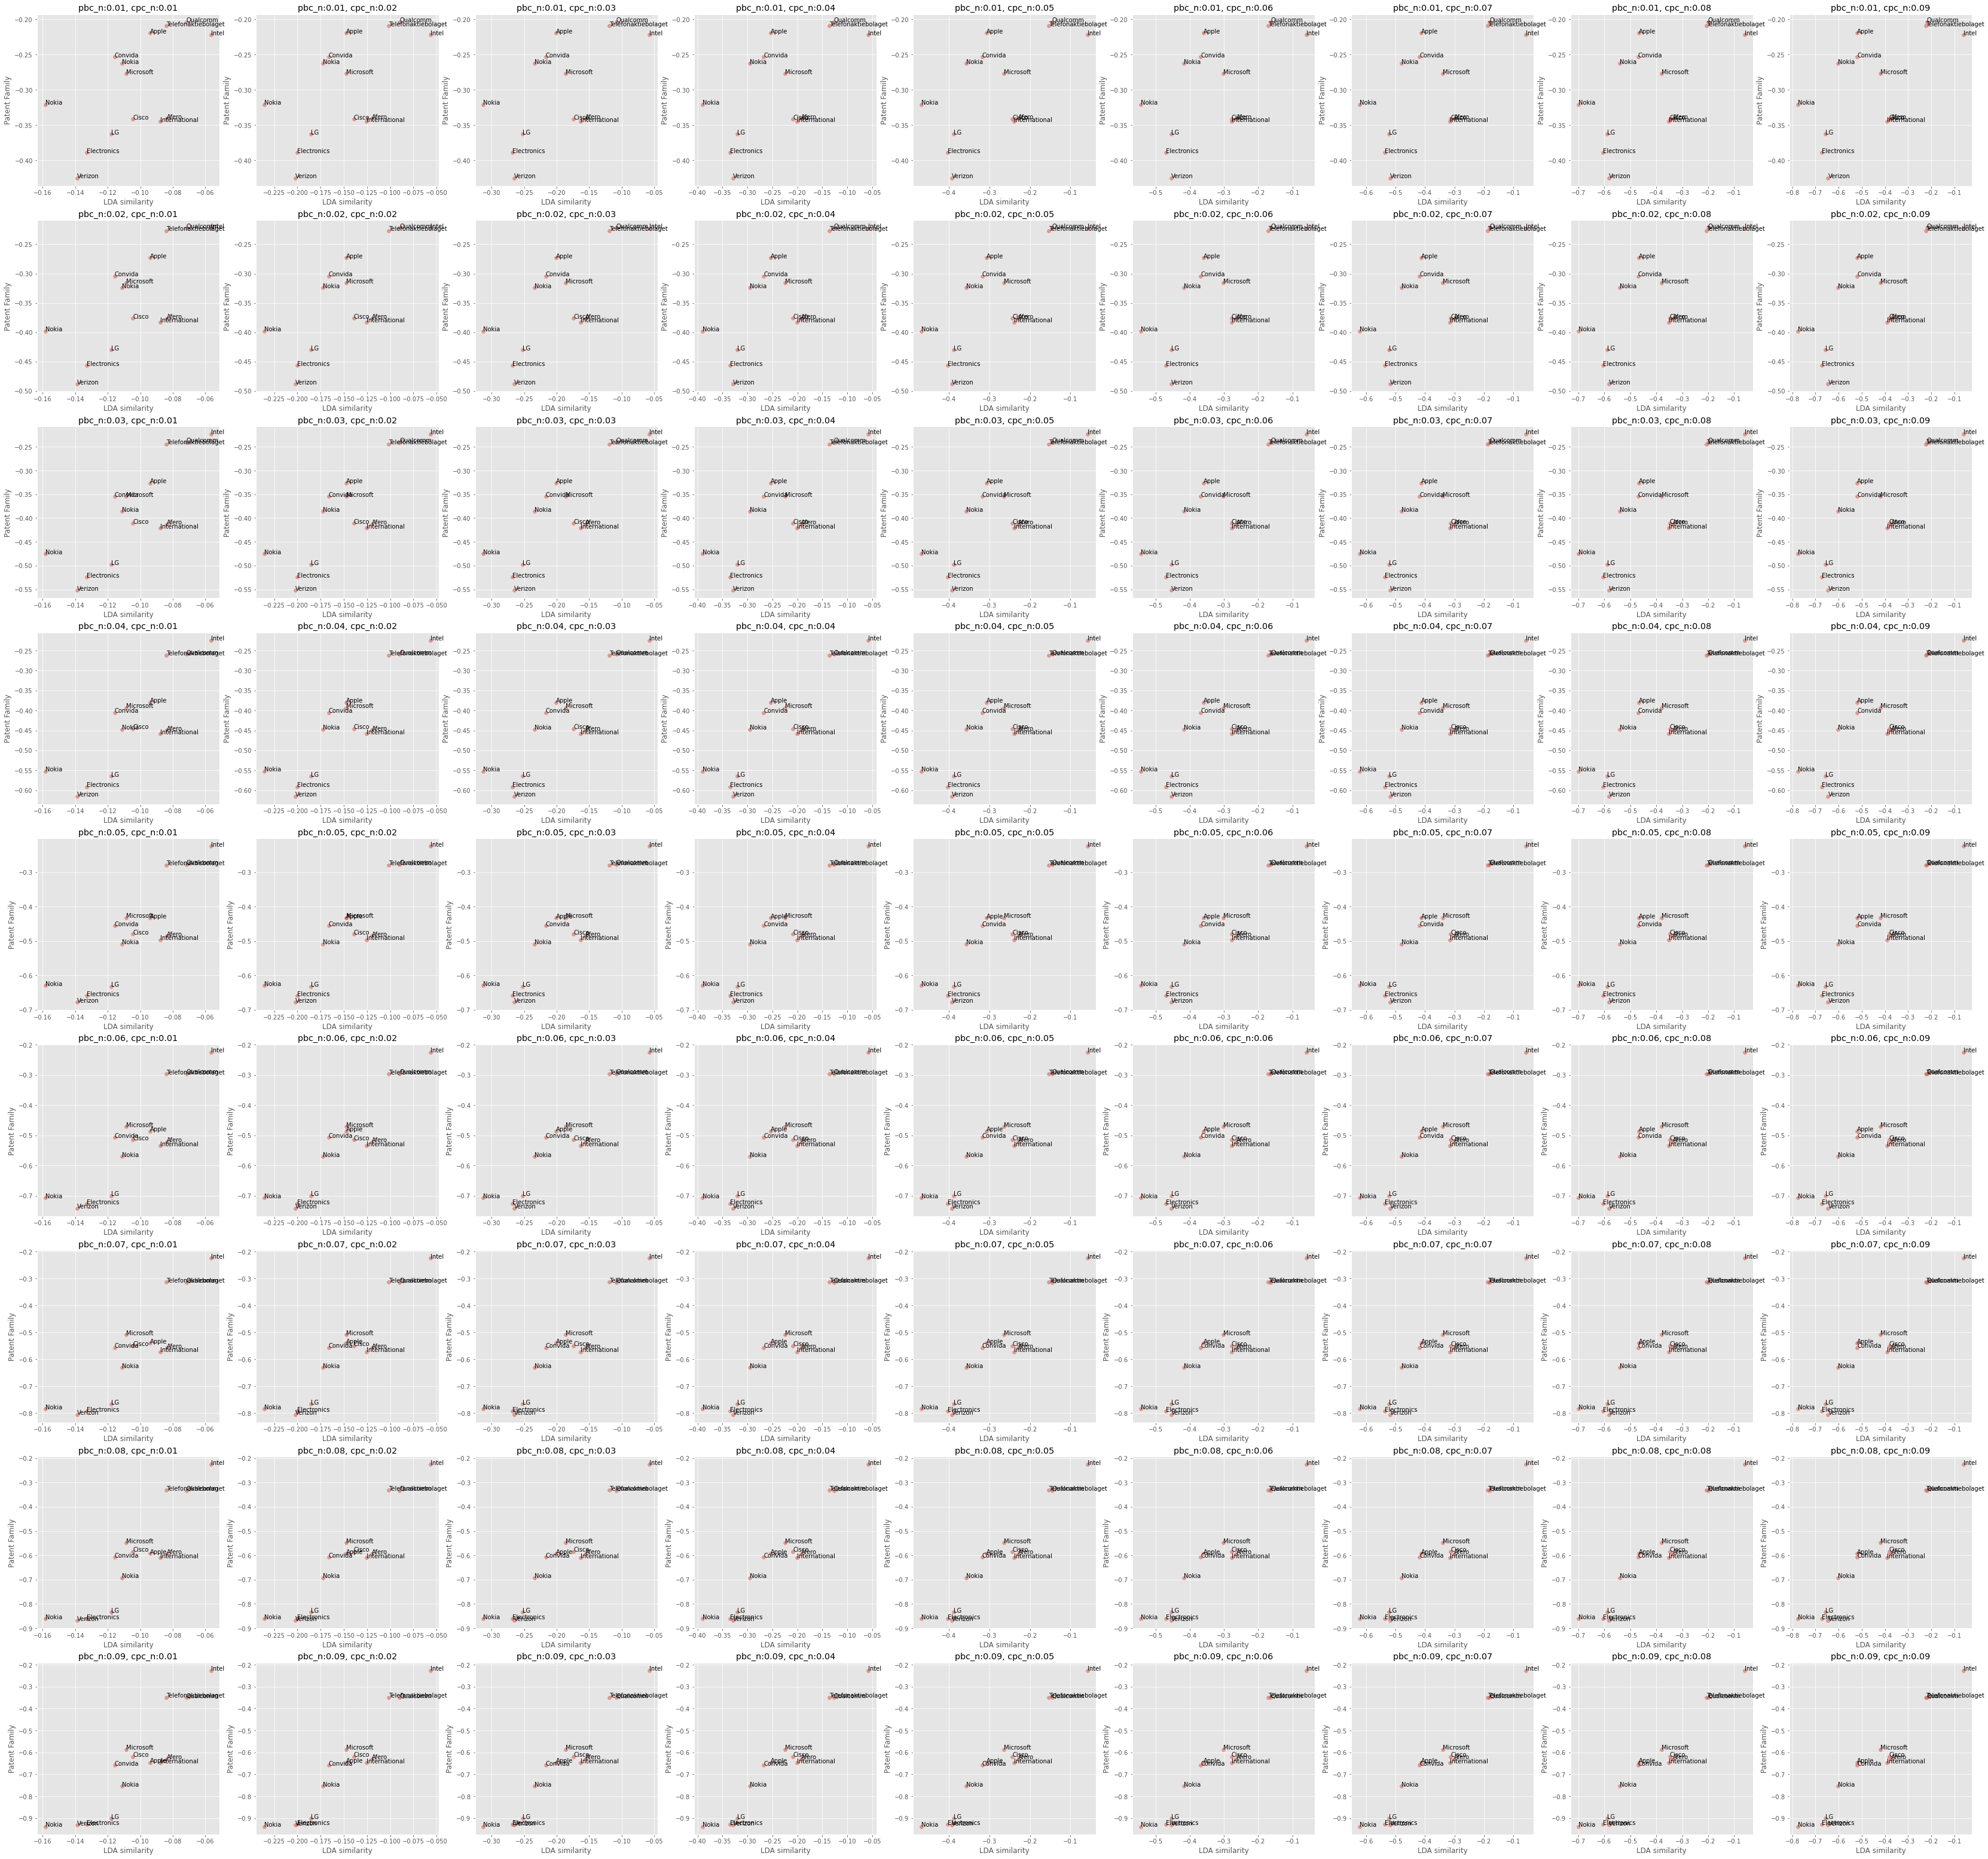

In [22]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("LDA similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_us_brief_2015_2.png'.format(pbc_n))

In [23]:
c_df

,cpc,country
company,,
Intel Corp,0.060041,0.225982
Telefonaktiebolaget LM Ericsson AB,0.223562,0.348837
Qualcomm Inc,0.218622,0.350981
Cisco Technology Inc,0.382149,0.618974
Afero Inc,0.373407,0.630410
International Business Machines Corp,0.390548,0.647998
Microsoft Technology Licensing LLC,0.418443,0.586912
Convida Wireless LLC,0.520110,0.658039
Apple Inc,0.520518,0.646072


In [24]:
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia"))
c_df.set_index("company", inplace=True)
c_df = c_df.drop("Samsung Electronics")

In [25]:
c_df

,cpc,country
company,,
Intel,0.060041,0.225982
Ericsson,0.223562,0.348837
Qualcomm,0.218622,0.350981
Cisco Systems,0.382149,0.618974
Afero,0.373407,0.630410
IBM,0.390548,0.647998
Microsoft,0.418443,0.586912
Convida Wireless LLC,0.520110,0.658039
Apple,0.520518,0.646072


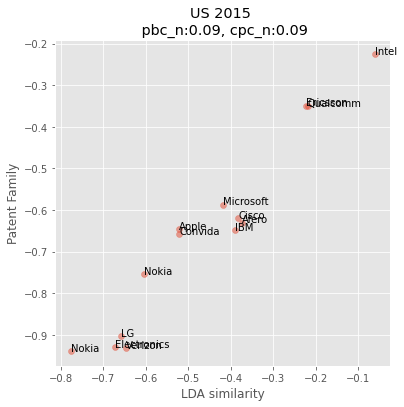

In [26]:
pbc_n=0.09
cpc_n=0.09
# c_df = scatter_plot(pbc_n,cpc_n)
# c_df = c_df.drop("Samsung Electronics Co Ltd")

plt.figure(figsize=(6,6))
plt.style.use('ggplot')
#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("US 2015 \n pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("LDA similarity")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [27]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [28]:
competitor_ls

[1, 1, 1, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4]

In [29]:
c_df

,cpc,country
company,,
Intel,0.060041,0.225982
Ericsson,0.223562,0.348837
Qualcomm,0.218622,0.350981
Cisco Systems,0.382149,0.618974
Afero,0.373407,0.630410
IBM,0.390548,0.647998
Microsoft,0.418443,0.586912
Convida Wireless LLC,0.520110,0.658039
Apple,0.520518,0.646072


In [30]:
c_df.to_csv("competitor_df/company/lda_us_2015.csv")

In [31]:
# 公司名稱和類別
c_ls = list(c_df.index)

In [32]:
competitor_df = pd.DataFrame((zip(c_ls, competitor_ls)), columns = ['company', '2015_competitor'])

In [33]:
competitor_df

,company,2015_competitor
0,Intel,1
1,Ericsson,1
2,Qualcomm,1
3,Cisco Systems,3
4,Afero,3
5,IBM,3
6,Microsoft,4
7,Convida Wireless LLC,4
8,Apple,4
9,Nokia,4


In [34]:
competitor_df.to_csv("competitor_df/lda_us_2015.csv", index=False)